In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from src.utils import visualize_metrics_plots
import time

# Reading the data
##data_742 = pd.read_csv("data_anno/crops_742.csv", sep=",", low_memory=True, nrows=5000) # Too large of a file xd, 9625 rows reduced to 5000
train_data_crop = pd.read_csv("data_anno/training_data_crops.csv", sep=",")
train_data_bbox = pd.read_csv("data_anno/training_data_coords.csv", sep=",")
X_crop, y_crop = train_data_crop[train_data_crop.columns[:-1]], train_data_crop[train_data_crop.columns[-1]]
X_bbox, y_bbox = train_data_bbox[train_data_bbox.columns[:-1]], train_data_bbox[train_data_bbox.columns[-1]]

##test_data = pd.read_csv("data_anno/testing_data_crops.csv", sep=",") # Original
##test_data = pd.read_csv("data_anno/testing_data_pair_crops.csv", sep=",") # Pairs
test_crop = pd.read_csv("data_anno/testing_data_crops.csv", sep=",") # Original
test_crop_pair = pd.read_csv("data_anno/testing_data_pair_crops.csv", sep=",") # Pairs
test_bbox = pd.read_csv("data_anno/testing_data_coords.csv", sep=",") # Original
test_bbox_pair = pd.read_csv("data_anno/testing_data_pair_coords.csv", sep=",") # Pairs


##data_741 = pd.read_csv("data_anno/crops_741.csv", sep=",")
##features = data_741[data_741.columns[:-1]] # Lets not assign variables to the data, too much memory usage
##labels = data_741[data_741.columns[-1]]


## Stratified splitting for train and test
## Stratified means that it maintains similar distributions of classes for both train and test
##X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42, stratify=labels) # Original
##X_train, X_test, y_train, y_test = train_test_split(data_741[data_741.columns[:-1]], data_741[data_741.columns[-1]], test_size=0.33, random_state=42, stratify=data_741[data_741.columns[-1]])

#train_data[train_data.columns[:-1]], train_data[train_data.columns[-1]]
# Oversampling ORIGINALLY DID THIS
sm1 = SMOTE(random_state=42)
sm2 = SMOTE(random_state=42)
X_res_crop, y_res_crop = sm1.fit_resample(train_data_crop[train_data_crop.columns[:-1]], train_data_crop[train_data_crop.columns[-1]])
X_res_bbox, y_res_bbox = sm2.fit_resample(train_data_bbox[train_data_bbox.columns[:-1]], train_data_bbox[train_data_bbox.columns[-1]])



le = LabelEncoder()
labels = ['human-hold-bicycle', 'human-ride-bicycle', 'human-ride-motorcycle', 'human-walk-bicycle', 'human-walk-motorcycle', 'human-hold-motorcycle']
le.fit(labels)

# Sampling strategy
sampling_strategy = {
    le.transform(['human-hold-bicycle'])[0]: 471,
    le.transform(['human-ride-bicycle'])[0]: 700,
    le.transform(['human-ride-motorcycle'])[0]: 493,
    le.transform(['human-walk-bicycle'])[0]: 744,
    le.transform(['human-hold-motorcycle'])[0]: 68,
}

# Undersampling
rus1 = RandomUnderSampler(sampling_strategy=sampling_strategy,random_state=0)
rus2 = RandomUnderSampler(sampling_strategy=sampling_strategy,random_state=0)
X_crop, y_crop = rus1.fit_resample(X_crop, y_crop)
X_bbox, y_bbox = rus2.fit_resample(X_bbox, y_bbox)

Oversampled crops:
label                
human-hold-bicycle       5902
human-hold-motorcycle    5902
human-ride-bicycle       5902
human-ride-motorcycle    5902
human-walk-bicycle       5902
Name: count, dtype: int64

Undersampled crops:
label                
human-walk-bicycle       744
human-ride-bicycle       700
human-ride-motorcycle    493
human-hold-bicycle       471
human-hold-motorcycle     68
Name: count, dtype: int64

Over/undersampled crops:
label                
human-hold-bicycle       744
human-hold-motorcycle    744
human-ride-bicycle       744
human-ride-motorcycle    744
human-walk-bicycle       744
Name: count, dtype: int64

Confusion Matrix of Test Classification
Trained on over/undersampled image crops
Accuracy: 0.6987399770904925 
Precision: 0.34185370686390454 
Recall: 0.3657937699650779 
F1 Score: 0.3249774416639234 
Time: 0.2769010066986084 
Labels:
0: ['human-hold-bicycle']
1: ['human-hold-motorcycle']
2: ['human-ride-bicycle']
3: ['human-ride-motorcycle']
4: [

<Figure size 640x480 with 0 Axes>

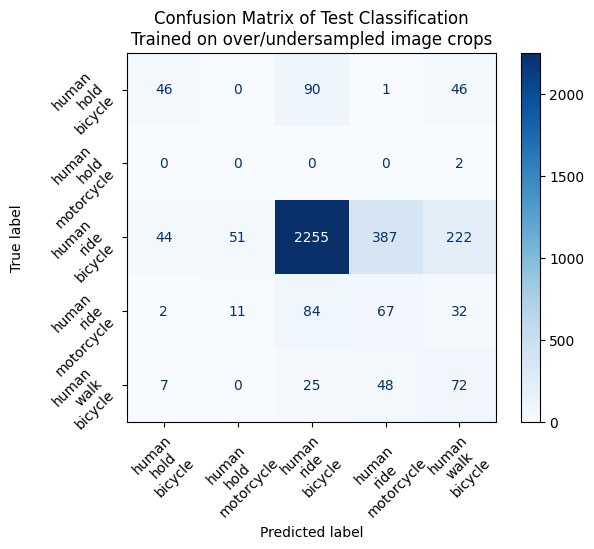

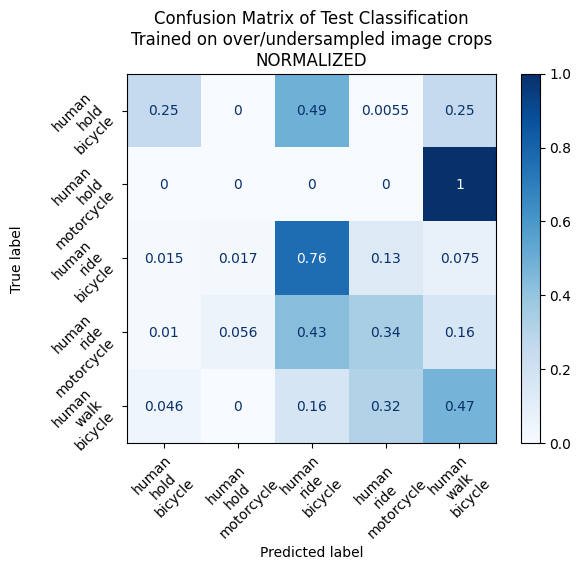

In [2]:
def counts(data, le):
    y_decoded = le.inverse_transform(data)
    y_decoded = pd.DataFrame(y_decoded, columns=["label"])
    print(y_decoded.value_counts())
    print()
    
le = LabelEncoder()
labels = ['human-hold-bicycle', 'human-ride-bicycle', 'human-ride-motorcycle', 'human-walk-bicycle', 'human-walk-motorcycle', 'human-hold-motorcycle']
le.fit(labels)

# Oversampled
#X_res_crop, y_res_crop
#X_res_bbox, y_res_bbox

# Undersampled
#X_crop, y_crop
#X_bbox, y_bbox

print("Oversampled crops:")
counts(y_res_crop,le)
print("Undersampled crops:")
counts(y_crop,le)
#print("Oversampled bboxes:")
#counts(y_res_bbox,le)
#print("Undersampled bboxes:")
#counts(y_bbox,le)

# Add under and oversampling
sm3 = SMOTE(random_state=42)
sm4 = SMOTE(random_state=42)
X_res_crop2, y_res_crop2 = sm1.fit_resample(X_crop, y_crop)
X_res_bbox2, y_res_bbox2 = sm2.fit_resample(X_bbox, y_bbox)

print("Over/undersampled crops:")
counts(y_res_crop2,le)
#print("Over/Undersampled bboxes:")
#counts(y_res_bbox,le)

# Training on paired/non-paired crops including over/undersampling
ests = 1000
seed = 0

clf_balanced_overunder = RandomForestClassifier(max_depth=None, random_state=seed, n_estimators=ests, n_jobs=-1)
clf_balanced_overunder.fit(X_res_crop2, y_res_crop2) # Original

#######################################################################################
params = f"Confusion Matrix of Test Classification\nTrained on over/undersampled image crops"
print(f"======================================================")
print(params)
visualize_metrics_plots(clf_balanced_overunder, test_crop[test_crop.columns[:-1]], test_crop[test_crop.columns[-1]],params,f"CROPS")
print(f"======================================================")

# Old simplified split

In [3]:
"""
data_741 = pd.read_csv("data_anno/data_741.csv", sep=",", low_memory=True, nrows=5000)
features = data_741[data_741.columns[:-1]] # Lets not assign variables to the data, too much memory usage
labels = data_741[data_741.columns[-1]]


# Stratified splitting for train and test
# Stratified means that it maintains similar distributions of classes for both train and test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42, stratify=labels) # Original

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

ests = 1000
seed = 0

clf_balancedq = RandomForestClassifier(max_depth=None, random_state=seed, n_estimators=ests, n_jobs=-1)
clf_balancedq.fit(X_res, y_res)
#clf_balanced.fit(train_data[train_data.columns[:-1]], train_data[train_data.columns[-1]])
#params = f"Balanced dataset\nTraining on crops\nDepth: None\nEstimators: {ests}"
params = f"Confusion Matrix of Test Classification\nTrained on image crops"
print(f"======================================================")
print(params)
visualize_metrics_plots(clf_balancedq, X_test, y_test,params,f"CROPS")
print(f"======================================================")
"""

'\ndata_741 = pd.read_csv("data_anno/data_741.csv", sep=",", low_memory=True, nrows=5000)\nfeatures = data_741[data_741.columns[:-1]] # Lets not assign variables to the data, too much memory usage\nlabels = data_741[data_741.columns[-1]]\n\n\n# Stratified splitting for train and test\n# Stratified means that it maintains similar distributions of classes for both train and test\nX_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42, stratify=labels) # Original\n\nsm = SMOTE(random_state=42)\nX_res, y_res = sm.fit_resample(X_train, y_train)\n\nests = 1000\nseed = 0\n\nclf_balancedq = RandomForestClassifier(max_depth=None, random_state=seed, n_estimators=ests, n_jobs=-1)\nclf_balancedq.fit(X_res, y_res)\n#clf_balanced.fit(train_data[train_data.columns[:-1]], train_data[train_data.columns[-1]])\n#params = f"Balanced dataset\nTraining on crops\nDepth: None\nEstimators: {ests}"\nparams = f"Confusion Matrix of Test Classification\nTrained on ima

In [4]:
"""
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

#data1 = pd.read_csv("data_anno/testing_data_crops.csv", sep=",") # Original
#data2 = pd.read_csv("data_anno/testing_data_pair_crops.csv", sep=",") # Pairs
data11 = pd.read_csv("data_anno/testing_data_coords.csv", sep=",") # Original
#data22 = pd.read_csv("data_anno/testing_data_pair_coords.csv", sep=",") # Pairs

train_data = pd.read_csv("data_anno/training_data_crops.csv", sep=",") 
#train_data = pd.read_csv("data_anno/training_data_coords.csv", sep=",")

print(data1)
print()
print(data2)
equal = data1.equals(data2)
print(data11.nunique())
if equal:
    print("\nThey are the same")
else:
    print("\nDifference!")
    diff = data1.compare(data2)
    print(diff)
    count_diff = diff.count()
    print(count_diff)


#le = LabelEncoder()
#labels = ['human-hold-bicycle', 'human-ride-bicycle', 'human-ride-motorcycle', 'human-walk-bicycle', 'human-walk-motorcycle', 'human-hold-motorcycle']
#le.fit(labels)

#data11["label"] = le.inverse_transform(data11["label"])
#train_data["label"] = le.inverse_transform(train_data["label"])

##print(data11["label"].value_counts())
##print("Total:",data11["label"].value_counts().sum())
#print(train_data["label"].value_counts())
#print("Total:",train_data["label"].value_counts().sum())

from imblearn.under_sampling import RandomUnderSampler
le = LabelEncoder()
labels = ['human-hold-bicycle', 'human-ride-bicycle', 'human-ride-motorcycle', 'human-walk-bicycle', 'human-walk-motorcycle', 'human-hold-motorcycle']
le.fit(labels)

X, y = train_data[train_data.columns[:-1]], train_data[train_data.columns[-1]]
print("Original:\n")
#print(X)
print(y)
print()
y_decoded = le.inverse_transform(y)
y_decoded = pd.DataFrame(y_decoded, columns=["label"])
print("Counts:\n", y_decoded.value_counts())
print()

#human-hold-bicycle        471
#human-ride-bicycle       5902
#human-ride-motorcycle     493
#human-walk-bicycle        744
#human-hold-motorcycle      68

sampling_strategy = {
    le.transform(['human-hold-bicycle'])[0]: 471,
    le.transform(['human-ride-bicycle'])[0]: 700,
    le.transform(['human-ride-motorcycle'])[0]: 493,
    le.transform(['human-walk-bicycle'])[0]: 744,
    le.transform(['human-hold-motorcycle'])[0]: 68,
}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy,random_state=0)
X_res, y_res = rus.fit_resample(X, y)

print("Undersampled:\n")
#print(X_res)
print(y_res)
y_res_decoded = le.inverse_transform(y_res)
y_res_decoded = pd.DataFrame(y_res_decoded, columns=["label"])
print("Counts:\n", y_res_decoded.value_counts())
"""

'\nfrom sklearn.preprocessing import LabelEncoder\nimport pandas as pd\nimport numpy as np\n\n#data1 = pd.read_csv("data_anno/testing_data_crops.csv", sep=",") # Original\n#data2 = pd.read_csv("data_anno/testing_data_pair_crops.csv", sep=",") # Pairs\ndata11 = pd.read_csv("data_anno/testing_data_coords.csv", sep=",") # Original\n#data22 = pd.read_csv("data_anno/testing_data_pair_coords.csv", sep=",") # Pairs\n\ntrain_data = pd.read_csv("data_anno/training_data_crops.csv", sep=",") \n#train_data = pd.read_csv("data_anno/training_data_coords.csv", sep=",")\n\nprint(data1)\nprint()\nprint(data2)\nequal = data1.equals(data2)\nprint(data11.nunique())\nif equal:\n    print("\nThey are the same")\nelse:\n    print("\nDifference!")\n    diff = data1.compare(data2)\n    print(diff)\n    count_diff = diff.count()\n    print(count_diff)\n\n\n#le = LabelEncoder()\n#labels = [\'human-hold-bicycle\', \'human-ride-bicycle\', \'human-ride-motorcycle\', \'human-walk-bicycle\', \'human-walk-motorcycle\'

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = ['human-hold-bicycle', 'human-ride-bicycle', 'human-ride-motorcycle', 'human-walk-bicycle', 'human-walk-motorcycle', 'human-hold-motorcycle']  

le.fit(labels)

#labels = [le.transform([label]).ravel() for label in labels]
labels = sorted(le.transform(labels))
print('Labels:')
print(labels)

#for i in labels:
#    #print(i)
#    print(f"{i}: {le.inverse_transform([i])}")
labels = [le.inverse_transform([i]) for i in labels]
labels = [label[0].replace("-", "\n") for label in labels]
print(labels)

for i in labels:
    print(f"'{i}'")


Labels:
[0, 1, 2, 3, 4, 5]
['human\nhold\nbicycle', 'human\nhold\nmotorcycle', 'human\nride\nbicycle', 'human\nride\nmotorcycle', 'human\nwalk\nbicycle', 'human\nwalk\nmotorcycle']
'human
hold
bicycle'
'human
hold
motorcycle'
'human
ride
bicycle'
'human
ride
motorcycle'
'human
walk
bicycle'
'human
walk
motorcycle'


# Training on crops

Confusion Matrix of Test Classification
Trained on oversampled image crops
Accuracy: 0.8278923253150057 
Precision: 0.4080311901025658 
Recall: 0.27811291424915574 
F1 Score: 0.3015687486525324 
Time: 0.6902000904083252 
Labels:
0: ['human-hold-bicycle']
1: ['human-hold-motorcycle']
2: ['human-ride-bicycle']
3: ['human-ride-motorcycle']
4: ['human-walk-bicycle']

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.17      0.28       183
           1       0.00      0.00      0.00         2
           2       0.87      0.95      0.91      2959
           3       0.24      0.09      0.13       196
           4       0.20      0.18      0.19       152

    accuracy                           0.83      3492
   macro avg       0.41      0.28      0.30      3492
weighted avg       0.80      0.83      0.80      3492



<Figure size 640x480 with 0 Axes>

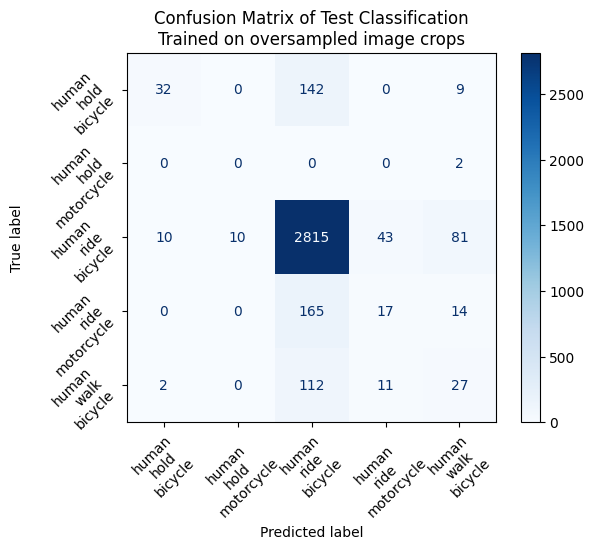

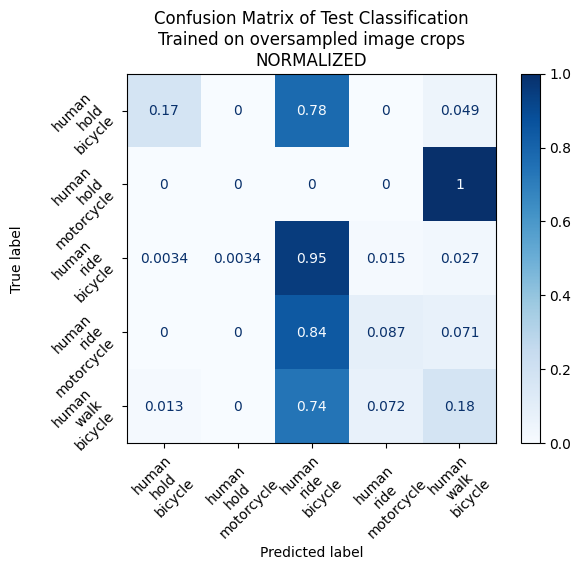

Confusion Matrix of Test Classification
Trained on oversampled image crop pairs
Accuracy: 0.8287514318442154 
Precision: 0.4134765849927319 
Recall: 0.27545723217233714 
F1 Score: 0.2976417059991335 
Time: 0.7830164432525635 
Labels:
0: ['human-hold-bicycle']
1: ['human-hold-motorcycle']
2: ['human-ride-bicycle']
3: ['human-ride-motorcycle']
4: ['human-walk-bicycle']

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.17      0.29       183
           1       0.00      0.00      0.00         2
           2       0.87      0.95      0.91      2959
           3       0.23      0.07      0.11       196
           4       0.19      0.18      0.18       152

    accuracy                           0.83      3492
   macro avg       0.41      0.28      0.30      3492
weighted avg       0.80      0.83      0.80      3492



<Figure size 640x480 with 0 Axes>

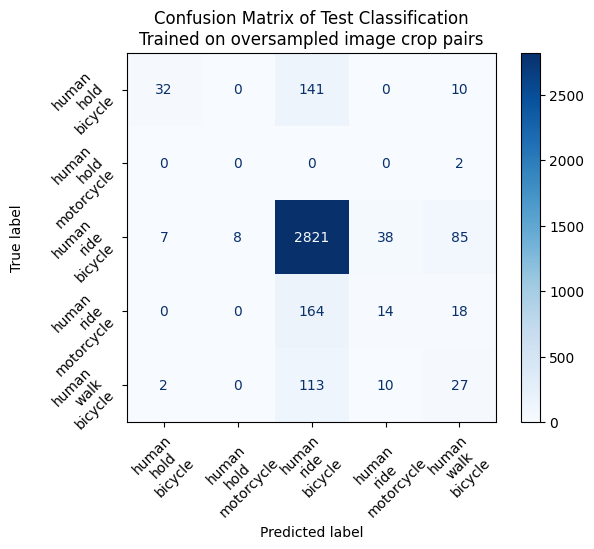

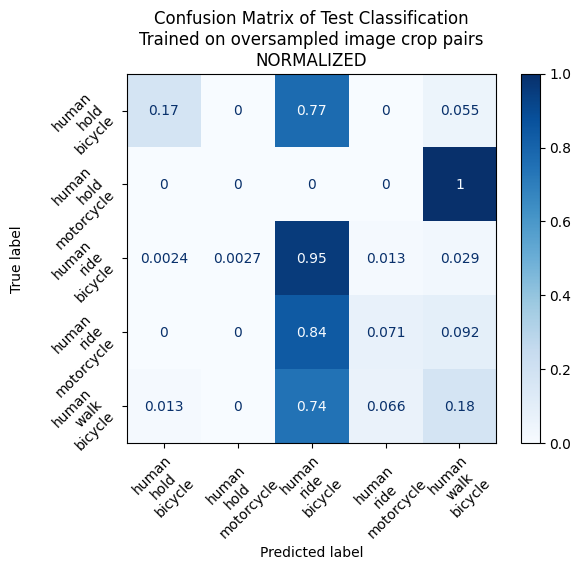

Confusion Matrix of Test Classification
Trained on undersampled image crops
Accuracy: 0.7408361970217641 
Precision: 0.3283912361210114 
Recall: 0.3712895375789661 
F1 Score: 0.3271605340353068 
Time: 0.78505539894104 
Labels:
0: ['human-hold-bicycle']
1: ['human-hold-motorcycle']
2: ['human-ride-bicycle']
3: ['human-ride-motorcycle']
4: ['human-walk-bicycle']

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.25      0.30       183
           1       0.00      0.00      0.00         2
           2       0.91      0.81      0.86      2959
           3       0.16      0.22      0.19       196
           4       0.19      0.57      0.29       152

    accuracy                           0.74      3492
   macro avg       0.33      0.37      0.33      3492
weighted avg       0.81      0.74      0.77      3492



<Figure size 640x480 with 0 Axes>

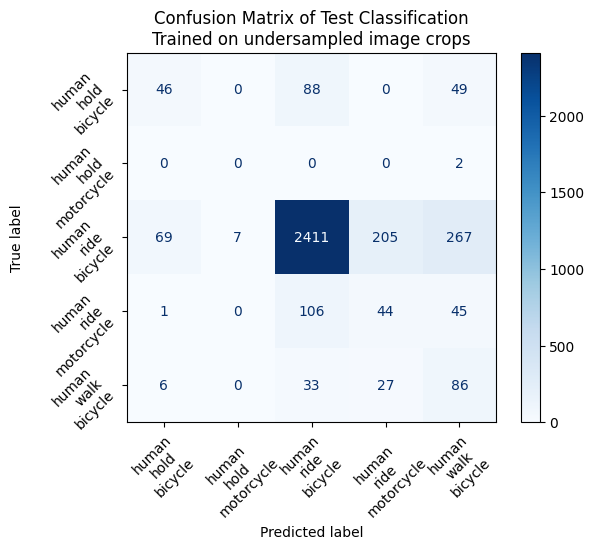

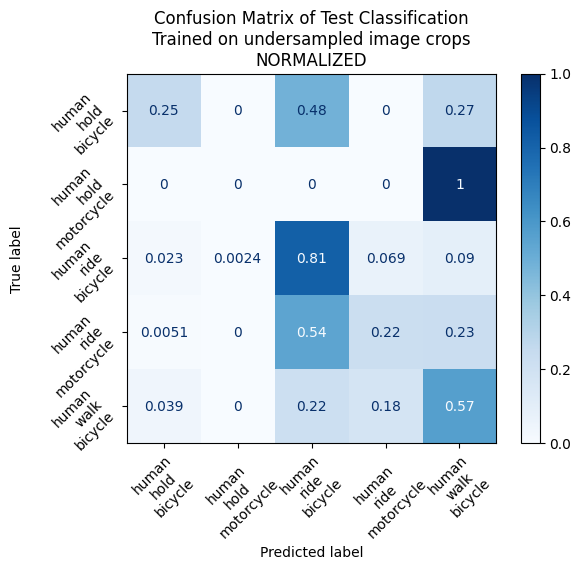

Confusion Matrix of Test Classification
Trained on undersampled image crop pairs
Accuracy: 0.7391179839633448 
Precision: 0.3461090370611818 
Recall: 0.36611990636047675 
F1 Score: 0.32686544698302816 
Time: 0.7594943046569824 
Labels:
0: ['human-hold-bicycle']
1: ['human-hold-motorcycle']
2: ['human-ride-bicycle']
3: ['human-ride-motorcycle']
4: ['human-walk-bicycle']

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.25      0.33       183
           1       0.00      0.00      0.00         2
           2       0.91      0.81      0.86      2959
           3       0.14      0.20      0.17       196
           4       0.18      0.57      0.27       152

    accuracy                           0.74      3492
   macro avg       0.35      0.37      0.33      3492
weighted avg       0.82      0.74      0.77      3492



<Figure size 640x480 with 0 Axes>

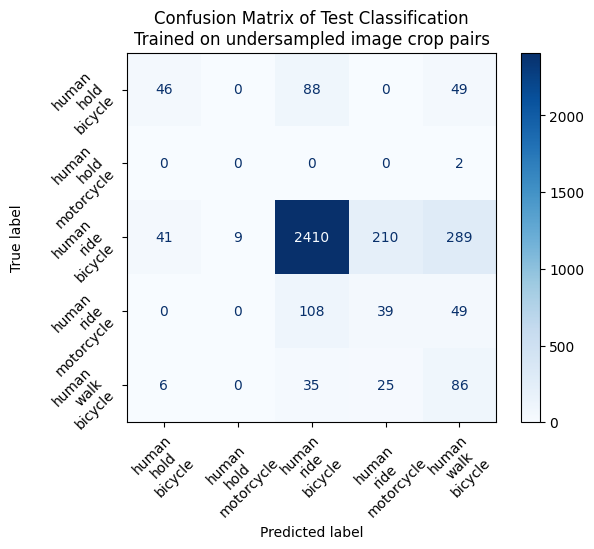

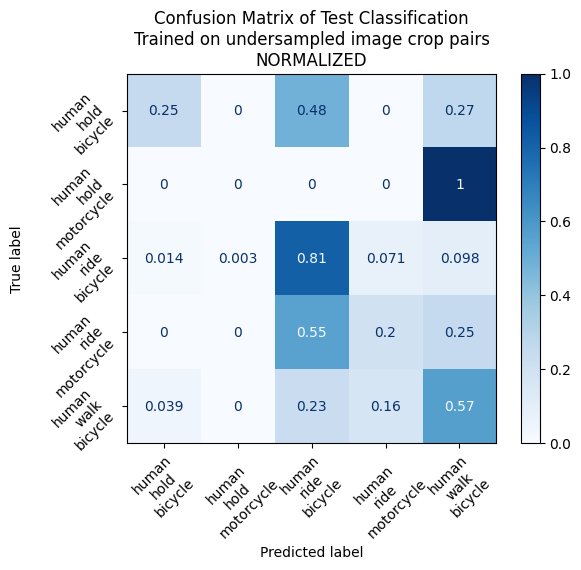

In [6]:
# Training on paired/non-paired crops including over/undersampling
ests = 1000
seed = 0

clf_balanced_over = RandomForestClassifier(max_depth=None, random_state=seed, n_estimators=ests, n_jobs=-1)
clf_balanced_under = RandomForestClassifier(max_depth=None, random_state=seed, n_estimators=ests, n_jobs=-1)
clf_balanced_over.fit(X_res_crop, y_res_crop) # Original
clf_balanced_under.fit(X_crop, y_crop)

#######################################################################################
params = f"Confusion Matrix of Test Classification\nTrained on oversampled image crops"
print(f"======================================================")
print(params)
visualize_metrics_plots(clf_balanced_over, test_crop[test_crop.columns[:-1]], test_crop[test_crop.columns[-1]],params,f"CROPS")
print(f"======================================================")

params = f"Confusion Matrix of Test Classification\nTrained on oversampled image crop pairs"
print(f"======================================================")
print(params)
visualize_metrics_plots(clf_balanced_over, test_crop_pair[test_crop_pair.columns[:-1]], test_crop_pair[test_crop_pair.columns[-1]],params,f"CROPS PAIR")
print(f"======================================================")

#######################################################################################

params = f"Confusion Matrix of Test Classification\nTrained on undersampled image crops"
print(f"======================================================")
print(params)
visualize_metrics_plots(clf_balanced_under, test_crop[test_crop.columns[:-1]], test_crop[test_crop.columns[-1]],params,f"CROPS")
print(f"======================================================")

params = f"Confusion Matrix of Test Classification\nTrained on undersampled image crop pairs"
print(f"======================================================")
print(params)
visualize_metrics_plots(clf_balanced_under, test_crop_pair[test_crop_pair.columns[:-1]], test_crop_pair[test_crop_pair.columns[-1]],params,f"CROPS PAIR")
print(f"======================================================")

# Training on coordinates

Confusion Matrix of Test Classification
Trained on oversampled bbox coordinates
Accuracy: 0.6927262313860252 
Precision: 0.2162728775086511 
Recall: 0.24090464129588543 
F1 Score: 0.21950289355800937 
Time: 0.4459049701690674 
Labels:
0: ['human-hold-bicycle']
1: ['human-hold-motorcycle']
2: ['human-ride-bicycle']
3: ['human-ride-motorcycle']
4: ['human-walk-bicycle']

Classification Report:
               precision    recall  f1-score   support

           0       0.03      0.01      0.01       183
           1       0.00      0.00      0.00         2
           2       0.86      0.79      0.82      2959
           3       0.08      0.17      0.11       196
           4       0.11      0.24      0.15       152

    accuracy                           0.69      3492
   macro avg       0.22      0.24      0.22      3492
weighted avg       0.74      0.69      0.71      3492



<Figure size 640x480 with 0 Axes>

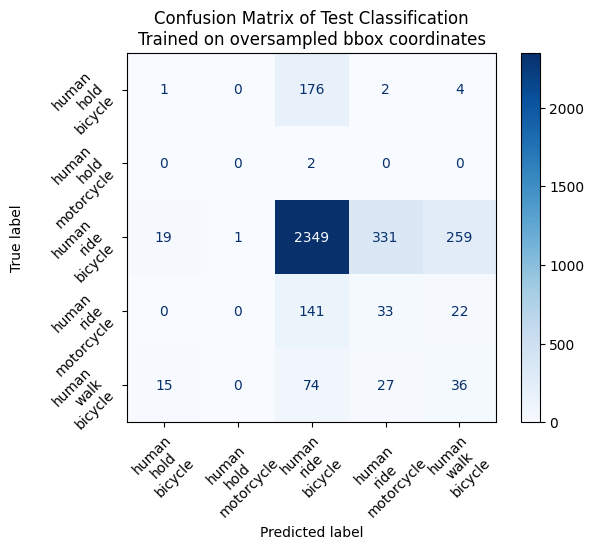

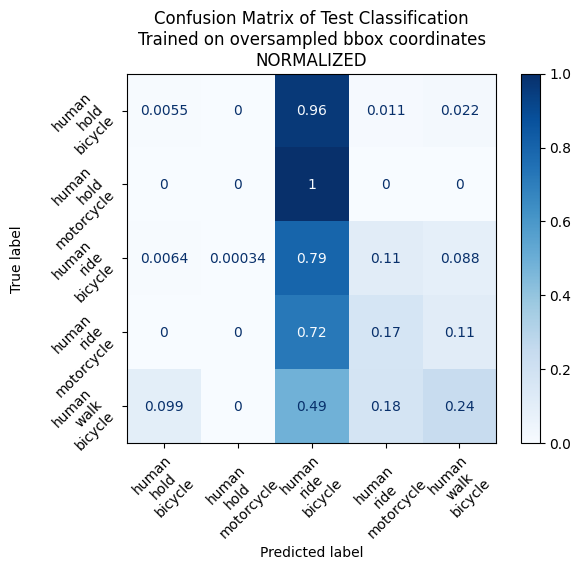

Confusion Matrix of Test Classification
Trained on oversampled bbox coordinates pairs
Accuracy: 0.6907216494845361 
Precision: 0.2113348941648388 
Recall: 0.23185614863082343 
F1 Score: 0.2133896519828015 
Time: 0.4453880786895752 
Labels:
0: ['human-hold-bicycle']
1: ['human-hold-motorcycle']
2: ['human-ride-bicycle']
3: ['human-ride-motorcycle']
4: ['human-walk-bicycle']

Classification Report:
               precision    recall  f1-score   support

           0       0.03      0.01      0.01       183
           1       0.00      0.00      0.00         2
           2       0.85      0.79      0.82      2959
           3       0.06      0.12      0.08       196
           4       0.11      0.24      0.15       152

    accuracy                           0.69      3492
   macro avg       0.21      0.23      0.21      3492
weighted avg       0.73      0.69      0.71      3492



<Figure size 640x480 with 0 Axes>

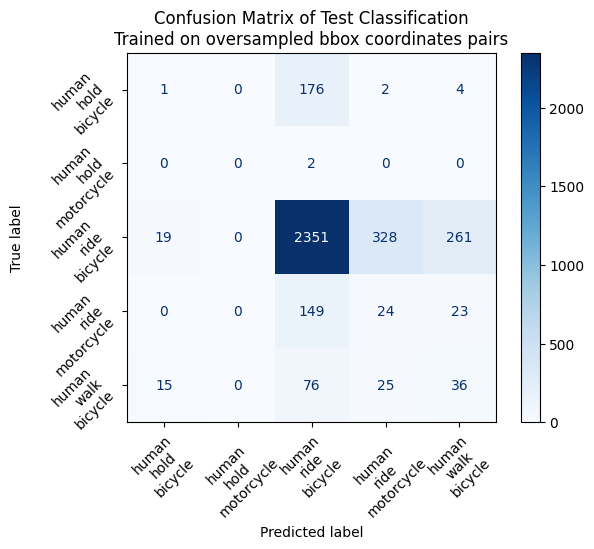

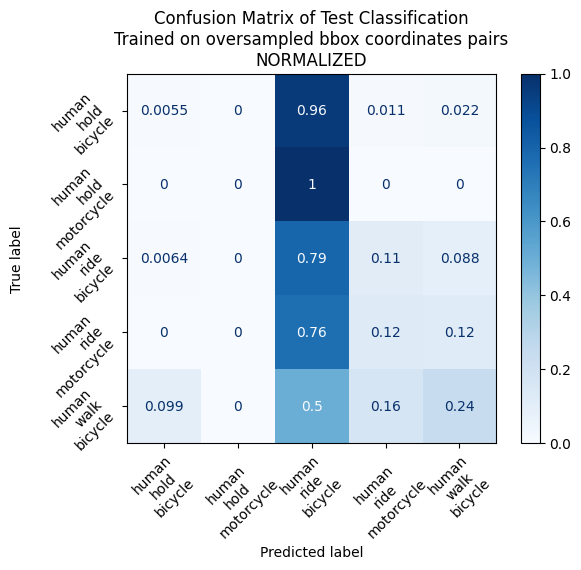

Confusion Matrix of Test Classification
Trained on undersampled bbox coordinates
Accuracy: 0.5146048109965635 
Precision: 0.21331379613454943 
Recall: 0.24610425622661253 
F1 Score: 0.19151791227241446 
Time: 0.4357011318206787 
Labels:
0: ['human-hold-bicycle']
1: ['human-hold-motorcycle']
2: ['human-ride-bicycle']
3: ['human-ride-motorcycle']
4: ['human-walk-bicycle']

Classification Report:
               precision    recall  f1-score   support

           0       0.01      0.01      0.01       183
           1       0.00      0.00      0.00         2
           2       0.89      0.57      0.69      2959
           3       0.09      0.30      0.14       196
           4       0.07      0.36      0.11       152

    accuracy                           0.51      3492
   macro avg       0.21      0.25      0.19      3492
weighted avg       0.76      0.51      0.60      3492



<Figure size 640x480 with 0 Axes>

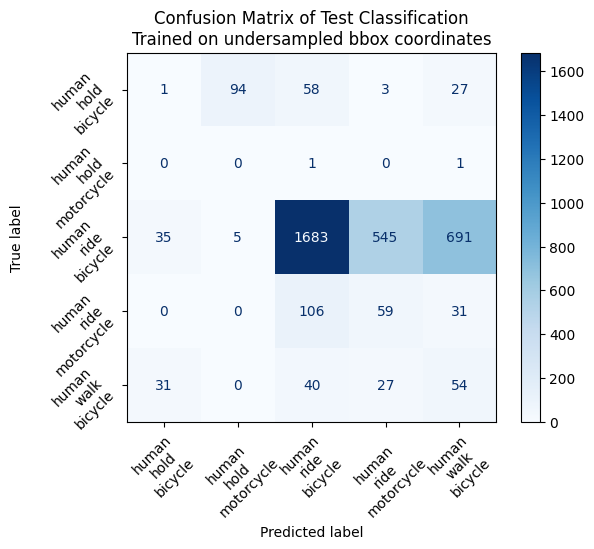

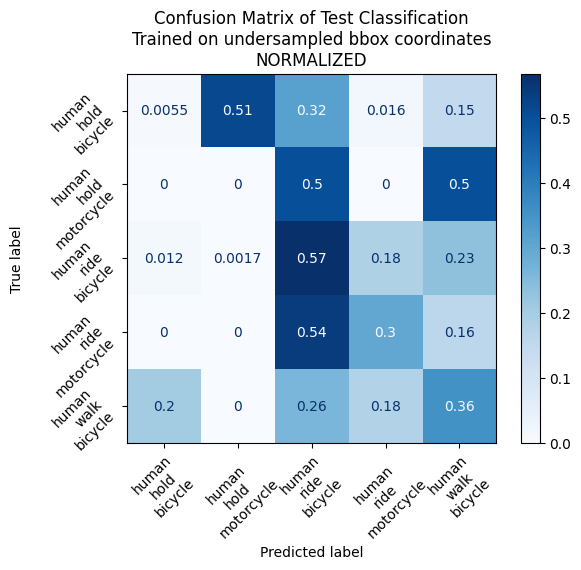

Confusion Matrix of Test Classification
Trained on undersampled bbox coordinates pairs
Accuracy: 0.5120274914089347 
Precision: 0.20913215721184727 
Recall: 0.23281393040239623 
F1 Score: 0.18573341215266198 
Time: 0.4370381832122803 
Labels:
0: ['human-hold-bicycle']
1: ['human-hold-motorcycle']
2: ['human-ride-bicycle']
3: ['human-ride-motorcycle']
4: ['human-walk-bicycle']

Classification Report:
               precision    recall  f1-score   support

           0       0.01      0.01      0.01       183
           1       0.00      0.00      0.00         2
           2       0.89      0.57      0.69      2959
           3       0.08      0.24      0.12       196
           4       0.07      0.35      0.11       152

    accuracy                           0.51      3492
   macro avg       0.21      0.23      0.19      3492
weighted avg       0.76      0.51      0.60      3492



<Figure size 640x480 with 0 Axes>

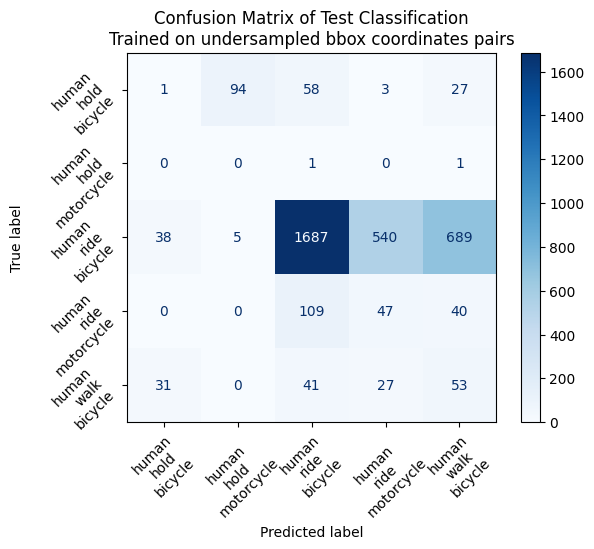

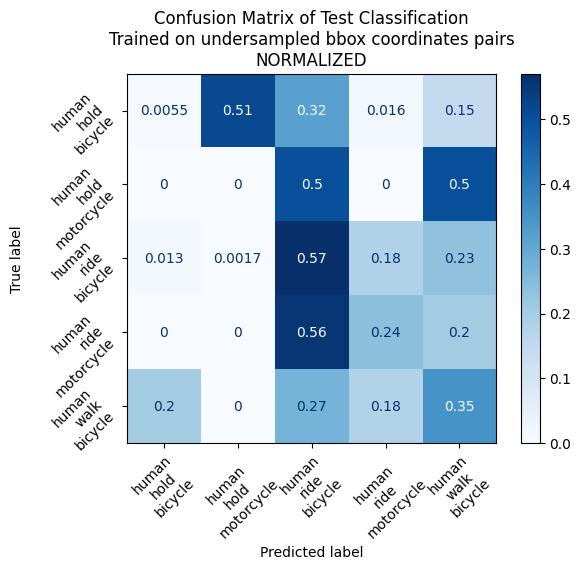

In [7]:
# Training on paired/non-paired bboxes including over/undersampling
ests = 1000
seed = 0

clf_balanced_over = RandomForestClassifier(max_depth=None, random_state=seed, n_estimators=ests, n_jobs=-1)
clf_balanced_under = RandomForestClassifier(max_depth=None, random_state=seed, n_estimators=ests, n_jobs=-1)
clf_balanced_over.fit(X_res_bbox, y_res_bbox) # Original
clf_balanced_under.fit(X_bbox, y_bbox)

#######################################################################################
params = f"Confusion Matrix of Test Classification\nTrained on oversampled bbox coordinates"
print(f"======================================================")
print(params)
visualize_metrics_plots(clf_balanced_over, test_bbox[test_bbox.columns[:-1]], test_bbox[test_bbox.columns[-1]],params,f"COORDS")
print(f"======================================================")

params = f"Confusion Matrix of Test Classification\nTrained on oversampled bbox coordinates pairs"
print(f"======================================================")
print(params)
visualize_metrics_plots(clf_balanced_over, test_bbox_pair[test_bbox_pair.columns[:-1]], test_bbox_pair[test_bbox_pair.columns[-1]],params,f"COORDS")
print(f"======================================================")

#######################################################################################

params = f"Confusion Matrix of Test Classification\nTrained on undersampled bbox coordinates"
print(f"======================================================")
print(params)
visualize_metrics_plots(clf_balanced_under, test_bbox[test_bbox.columns[:-1]], test_bbox[test_bbox.columns[-1]],params,f"COORDS")
print(f"======================================================")

params = f"Confusion Matrix of Test Classification\nTrained on undersampled bbox coordinates pairs"
print(f"======================================================")
print(params)
visualize_metrics_plots(clf_balanced_under, test_bbox_pair[test_bbox_pair.columns[:-1]], test_bbox_pair[test_bbox_pair.columns[-1]],params,f"COORDS")
print(f"======================================================")

# Random testing

In [8]:
# Run separately, runs out of memory lols, lowering data from 5000 rows to 4000
#ests = 1000
#seed = 0
#depths = [None]
#strats = ["all", "auto"]

#for i, depth in enumerate(depths):
#    for j, strat in enumerate(strats):
#        clf_doublebalanced = BalancedRandomForestClassifier(
#            sampling_strategy=strat,
#            replacement=True,
#            max_depth=depth,
#            random_state=seed,
#            n_estimators=ests,
#            n_jobs=-1,
#        )
#        clf_doublebalanced.fit(X_res, y_res)
#        params = f"Double-balanced dataset {i}-{strat}\ndepth = {depth}\nresampling_strategy = {strat}"
#        print(f"======================================================")
#        print(params)
#        visualize_metrics_plots(clf_doublebalanced, test_data[test_data.columns[:-1]], test_data[test_data.columns[-1]], params, f"Double-balanced dataset {depth}-{strat}")
#        print(f"======================================================")


"""
for i in range(3):
    clf_unbalanced = RandomForestClassifier(max_depth=depth[i], random_state=seed, n_estimators=ests, n_jobs=-1)
    clf_unbalanced.fit(X_train, y_train)
    params = f"Unbalanced dataset {i}\ndepth = {depth[i]}"
    print(f"======================================================")
    print(params)
    visualize_metrics(clf_unbalanced, X_test, y_test, params,f"Unbalanced dataset {i}")
    print(f"======================================================")

for i in range(3):
    for j in range(2):
        clf_semibalanced = BalancedRandomForestClassifier(
            sampling_strategy=strat[j],
            replacement=True,
            max_depth=depth[i],
            random_state=seed,
            n_estimators=ests,
            n_jobs=-1,
        )
        clf_semibalanced.fit(X_train, y_train)
        params = f"Semi-balanced dataset {i}-{strat[j]}\ndepth = {depth[i]}\nresampling_strategy = {strat[j]}"
        print(f"======================================================")
        print(params)
        visualize_metrics(clf_semibalanced, X_test, y_test, params, f"Semi-balanced dataset {depth[i]}-{strat[j]}")
        print(f"======================================================")
"""

'\nfor i in range(3):\n    clf_unbalanced = RandomForestClassifier(max_depth=depth[i], random_state=seed, n_estimators=ests, n_jobs=-1)\n    clf_unbalanced.fit(X_train, y_train)\n    params = f"Unbalanced dataset {i}\ndepth = {depth[i]}"\n    print(f"======================================================")\n    print(params)\n    visualize_metrics(clf_unbalanced, X_test, y_test, params,f"Unbalanced dataset {i}")\n    print(f"======================================================")\n\nfor i in range(3):\n    for j in range(2):\n        clf_semibalanced = BalancedRandomForestClassifier(\n            sampling_strategy=strat[j],\n            replacement=True,\n            max_depth=depth[i],\n            random_state=seed,\n            n_estimators=ests,\n            n_jobs=-1,\n        )\n        clf_semibalanced.fit(X_train, y_train)\n        params = f"Semi-balanced dataset {i}-{strat[j]}\ndepth = {depth[i]}\nresampling_strategy = {strat[j]}"\n        print(f"===========================